# Data Exploration Report 
Alyssa Nguyen, Eva Rickard, Audrey Kimball

## Introduction:

For our project, we are examining the relationship between a multitude of different health-related outcomes and the social metrics measured by neighborhoods in Seattle. These health outcomes can be found in our Problem Set 2, but range from the share of adults with obesity, asthma, and poor mental health, to those with low life expectancy at birth, and more. The same dataset also measures social factors such as the share of population at different age ranges, the number of people of color, and the proportion of residents who are foreign-born or speak English less than well. Our second dataset provides insight into the population of certain ages who are disabled and their insurance status. It is important to note that this is all post–Affordable Care Act implementation, so insurance is not mandatory.

### Datasets

- [Racial and Social Equity Index — Seattle](https://data.seattle.gov/dataset/Racial-and-Social-Equity-Composite-Index-Current/x5s4-2aie/about_data)  
  *Combines information on race, ethnicity, and related demographics with data on socioeconomic and health disadvantages to identify where priority populations make up relatively large proportions of neighborhood residents.*

- [Disability and Health Insurance — Seattle Neighborhoods](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::disability-and-health-insurance-seattle-neighborhoods/about)  
  *Provides data on disability status and health insurance coverage across Seattle neighborhoods.*ds/about  

## Overview of Data Engineering Efforts: 

### Factor analysis: 

After we found the data sets that we wanted to use, we set out to explore and clean our datasets. To clean it, we first dropped all duplicates from both data frames, as well as stripped whitespace and changed all column names to lower case letters. After, we identified the outliers using the IQR method. We looped this through all the quantitative columns. However, after some team deliberation we decided to keep the outlier columns in the analysis because the way we join the datasets will average out from all the associated census districts. Having the outliers on hand will be useful if we find our data is giving us odd results; it is something we can look back on if needed. 
### Data Joining: 
 
To prepare the datasets for analysis, we used QGIS to spatially join the Disability and Health Insurance dataset with the Racial and Social Equity Composite Index. Because the two datasets were organized by different geographic units (census tracts vs. neighborhood boundaries),we aligned the boundaries using the Atlas dataset as a reference. Using the Join Attributes by Summary tool, we joined the Atlas layer to the composite index to create a new, cleaner boundary layer more consistent with the disability data. After that I ran the data through the cleaning code. We then created a Python mapping dictionary to merge the smaller and duplicate neighborhoods names into larger composite neighborhoods. This process created a combined clean data set.

## Data Visualization: 
In this section, I refined the visualizations from the previous assignment to enhance readability and visual appeal. For majority of the graphs I transitioned from basic Matplotlib charts to Seaborn visualizations to create more polished, cohesive figures with improved color palettes and clearer labeling. Each figure now includes a figure number and concise caption for easier reference and reproducibility.

The updated graphics continue to highlight key patterns and relationships within the dataset, but the enhanced design allows for more immediate interpretation of trends and outliers. These improvements make it easier to communicate the underlying story of the data while maintaining consistency across visual elements.

In [3]:
# Imports, folders, select base columns needed for analysis 
import pandas as pd 
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
import os

#Global Aesthetics and Helper Function 
sns.set_theme(style="white", rc={"axes.facecolor": "white"})
plt.rcParams['figure.figsize'] = (10, 6) # Consistent figure size
plt.rcParams['font.family'] = 'sans-serif' 

MAIN_COLOR = '#348AA7'      # PrimaryBlue/Teal for general data
HIGHLIGHT_COLOR = '#E55934' # Secondary Orange/Red for emphasis/trendlines

# Create a global figure counter to automatically number figures 
figure_counter = 1

def add_caption(caption, offset=-0.02):
    """
    Adds an auto-numbered caption below the current figure.
    - caption: text for the caption (without the word 'Figure')
    - offset: vertical position adjustment (default -0.02)
    """
    global figure_counter
    plt.figtext(0.5, offset, f"Figure {figure_counter}. {caption}",
                ha='center', fontsize=10, wrap=True)
    figure_counter += 1

#Data loading and prep
df = pd.read_csv(r"C:\Users\alyss\OneDrive - Washington State University (email.wsu.edu)\Data 422\disability_composite_joined.csv")

essential_cols = [
    'neighborhood_name',
    'population_without_health_insurance',
    'population_civilian_noninstitutionalized',
    'population_18_years_and_over_with_a_disability',
    'population_18_years_and_over',
    'health_disadv_score_mean',
    'composite_score_mean',
    'pct_pop_under200pct_poverty_mean',
    'pct_adult_with_disability_mean'
]

df_clean = df[essential_cols].copy() 

# Calulate % uninsured 
df_clean['percent_uninsured'] = (
    df_clean['population_without_health_insurance'] / df_clean['population_civilian_noninstitutionalized']
) * 100

# Calculate % of adults with disability 
df_clean['percent_adults_with_disability'] = (
    df_clean['population_18_years_and_over_with_a_disability'] / df_clean['population_18_years_and_over']
) * 100

# Make population_count 
df_clean['population_count'] = df_clean['population_civilian_noninstitutionalized']

# Rename aggregated mean predictors for analysis use
df_clean = df_clean.rename(columns={
    'health_disadv_score_mean': 'health_disadvantage_score_AVG',
    'composite_score_mean': 'composite_score_AVG',
    'pct_pop_under200pct_poverty_mean': 'poverty_rate_avg',
    'pct_adult_with_disability_mean': 'disability_rate_mean_of_ratios_AVG'
})

# Filter to keep only the 84 rows with complete data for the main analysis (trimming)
df_analysis = df_clean.dropna(subset=['percent_uninsured']).reset_index(drop=True)

#final list of columns 
final_cols = [
    'neighborhood_name',
    'percent_uninsured',
    'percent_adults_with_disability',
    'health_disadvantage_score_AVG',
    'composite_score_AVG',
    'poverty_rate_avg',
    'population_count',
    'disability_rate_mean_of_ratios_AVG'
]

df_final = df_analysis[final_cols]

# Save the new file
path = os.path.join("C:/Users/alyss/OneDrive - Washington State University (email.wsu.edu)/Data 422", "final_analysis_data.csv")
df_final.to_csv(path, index=False)

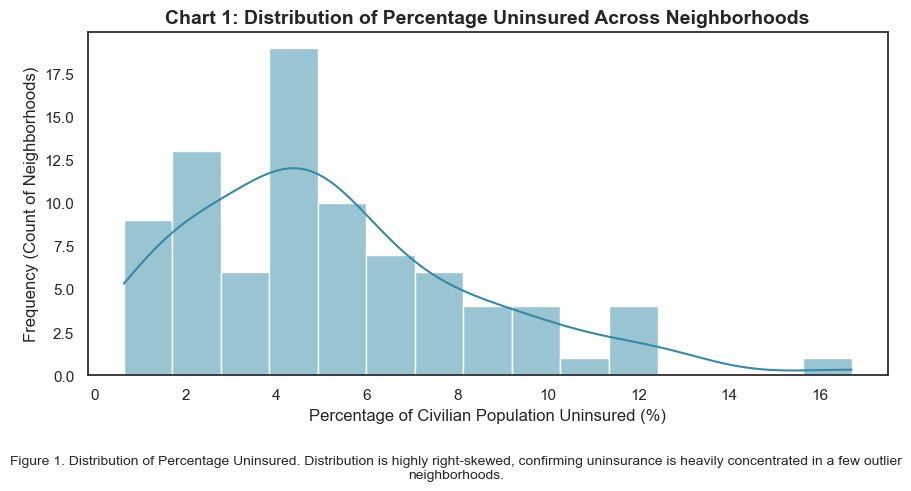

In [4]:
# Chart 1/10: Histogram of % uninsured
plt.figure(figsize=(9, 5))
sns.histplot(df_final['percent_uninsured'], bins=15, kde=True, color=MAIN_COLOR, edgecolor='white')
plt.title('Chart 1: Distribution of Percentage Uninsured Across Neighborhoods', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Civilian Population Uninsured (%)', fontsize=12)
plt.ylabel('Frequency (Count of Neighborhoods)', fontsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("Distribution of Percentage Uninsured. Distribution is highly right-skewed, confirming uninsurance is heavily concentrated in a few outlier neighborhoods.")
plt.show()

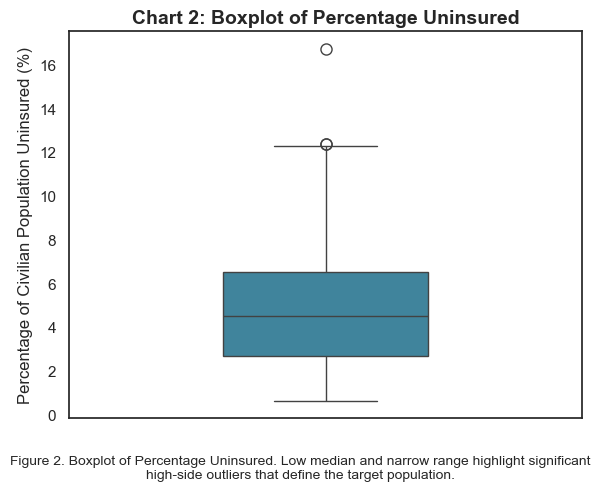

In [7]:
# Chart 2/10: Boxplot of % uninsured
plt.figure(figsize=(6, 5))
sns.boxplot(y=df_final['percent_uninsured'], color=MAIN_COLOR, width=0.4, fliersize=8, saturation=0.8)
plt.title('Chart 2: Boxplot of Percentage Uninsured', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Civilian Population Uninsured (%)', fontsize=12)
plt.xticks([]) # Remove x-ticks
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("Boxplot of Percentage Uninsured. Low median and narrow range highlight significant high-side outliers that define the target population.")
plt.show()

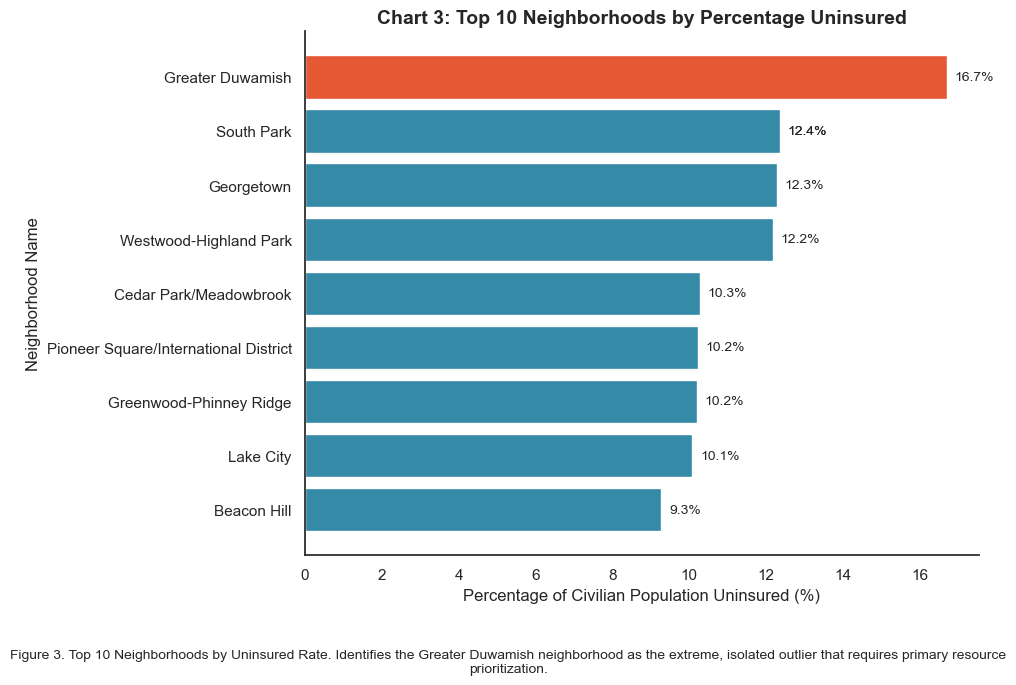

In [9]:
top_10 = df_final.nlargest(10, 'percent_uninsured').sort_values(by='percent_uninsured', ascending=True)

plt.figure(figsize=(10, 7))
colors = [HIGHLIGHT_COLOR if name == 'Greater Duwamish' else MAIN_COLOR for name in top_10['neighborhood_name']]

bars = plt.barh(top_10['neighborhood_name'], top_10['percent_uninsured'], color=colors)

# Add data labels directly on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.2, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
             va='center', fontsize=10, fontweight='medium')

plt.title('Chart 3: Top 10 Neighborhoods by Percentage Uninsured', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Civilian Population Uninsured (%)', fontsize=12)
plt.ylabel('Neighborhood Name', fontsize=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("Top 10 Neighborhoods by Uninsured Rate. Identifies the Greater Duwamish neighborhood as the extreme, isolated outlier that requires primary resource prioritization.")
plt.show()


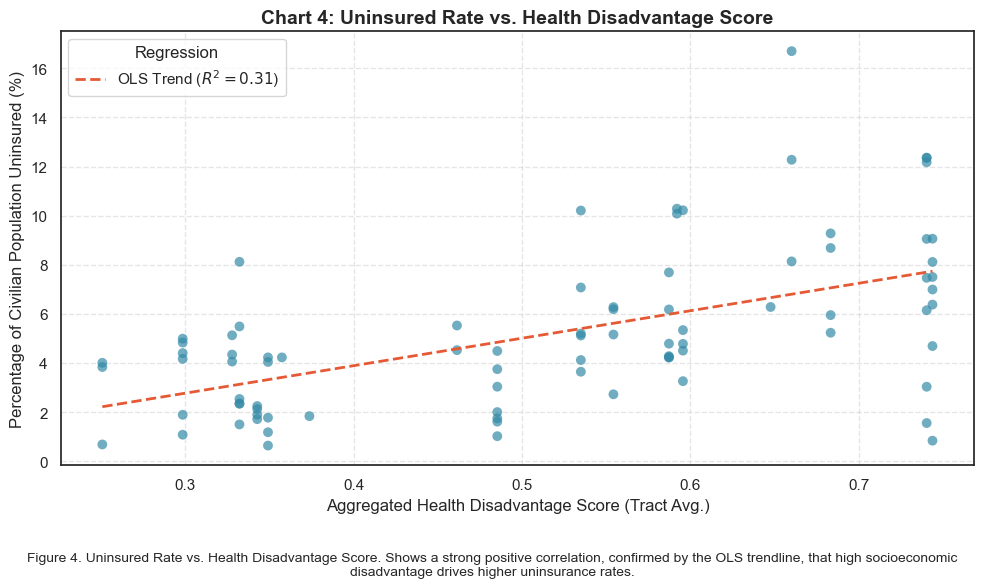

In [11]:
# Chart 4/10: Scatterplot of % uninsured vs health disadvantage score
plt.figure(figsize=(10, 6))

# Scatter Plot
plt.scatter(df_final['health_disadvantage_score_AVG'], df_final['percent_uninsured'],
            color=MAIN_COLOR, alpha=0.7, s=50, edgecolors='none')

# Add Linear Regression Trendline and R-squared
X = sm.add_constant(df_final['health_disadvantage_score_AVG'])
model = sm.OLS(df_final['percent_uninsured'], X).fit()
x_fit = np.linspace(df_final['health_disadvantage_score_AVG'].min(), df_final['health_disadvantage_score_AVG'].max(), 100)
y_fit = model.predict(sm.add_constant(x_fit))

plt.plot(x_fit, y_fit, color=HIGHLIGHT_COLOR, linestyle='--', linewidth=2, label=f'OLS Trend ($R^2={model.rsquared:.2f}$)')
plt.legend(frameon=True, loc='upper left', title="Regression")

plt.title('Chart 4: Uninsured Rate vs. Health Disadvantage Score', fontsize=14, fontweight='bold')
plt.xlabel('Aggregated Health Disadvantage Score (Tract Avg.)', fontsize=12)
plt.ylabel('Percentage of Civilian Population Uninsured (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("Uninsured Rate vs. Health Disadvantage Score. Shows a strong positive correlation, confirmed by the OLS trendline, that high socioeconomic disadvantage drives higher uninsurance rates.")
plt.show()

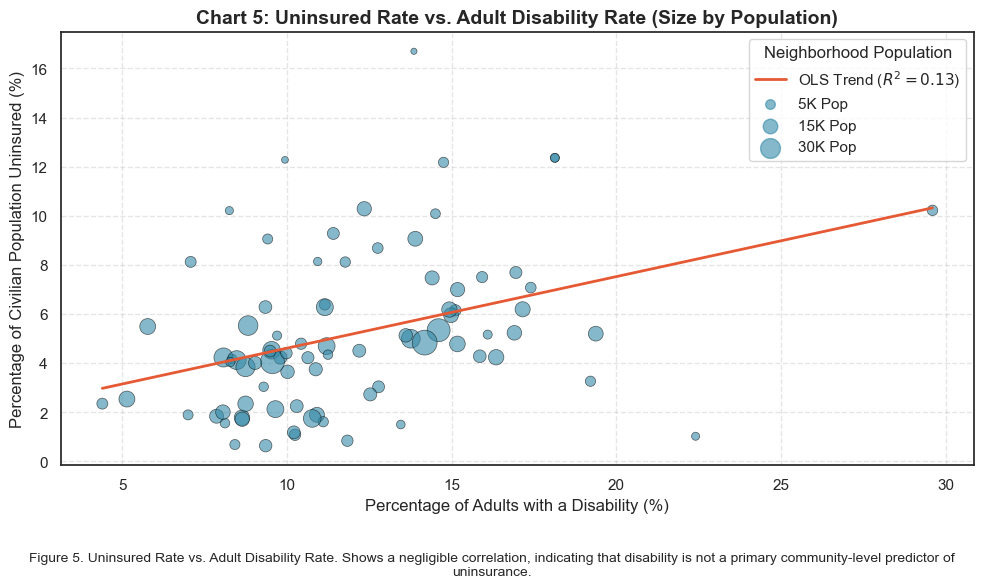

In [13]:
# Helper function for scaling population for size in scatterplots
pop_min = df_final['population_count'].min()
pop_max = df_final['population_count'].max()
size_scaled = 20 + 300 * (df_final['population_count'] - pop_min) / (pop_max - pop_min)

# Chart 5/10: Scatterplot of % uninsured vs % of adults with disability (size proportional to pop)
plt.figure(figsize=(10, 6))
plt.scatter(df_final['percent_adults_with_disability'], df_final['percent_uninsured'],
            s=size_scaled, color=MAIN_COLOR, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add Linear Regression Trendline (will show low R^2)
X = sm.add_constant(df_final['percent_adults_with_disability'])
model = sm.OLS(df_final['percent_uninsured'], X).fit()
x_fit = np.linspace(df_final['percent_adults_with_disability'].min(), df_final['percent_adults_with_disability'].max(), 100)
y_fit = model.predict(sm.add_constant(x_fit))

plt.plot(x_fit, y_fit, color=HIGHLIGHT_COLOR, linestyle='-', linewidth=2, label=f'OLS Trend ($R^2={model.rsquared:.2f}$)')
plt.legend(frameon=True, loc='upper right', title="Regression")

plt.title('Chart 5: Uninsured Rate vs. Adult Disability Rate (Size by Population)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Adults with a Disability (%)', fontsize=12)
plt.ylabel('Percentage of Civilian Population Uninsured (%)', fontsize=12)

# Manual legend for size
for pop_val in [5000, 15000, 30000]:
    pop_scaled_val = 20 + 300 * (pop_val - pop_min) / (pop_max - pop_min)
    plt.scatter([], [], s=pop_scaled_val, label=f'{pop_val/1000:.0f}K Pop', color=MAIN_COLOR, alpha=0.6)

plt.legend(scatterpoints=1, frameon=True, loc='upper right', title="Neighborhood Population")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("Uninsured Rate vs. Adult Disability Rate. Shows a negligible correlation, indicating that disability is not a primary community-level predictor of uninsurance.")
plt.show()


C:\Users\alyss\AppData\Local\Temp\ipykernel_27696\3106184245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.loc[:, 'disadvantage_group'] = np.where(df_final['health_disadvantage_score_AVG'] > median_disadv, 'High Disadvantage', 'Low Disadvantage')


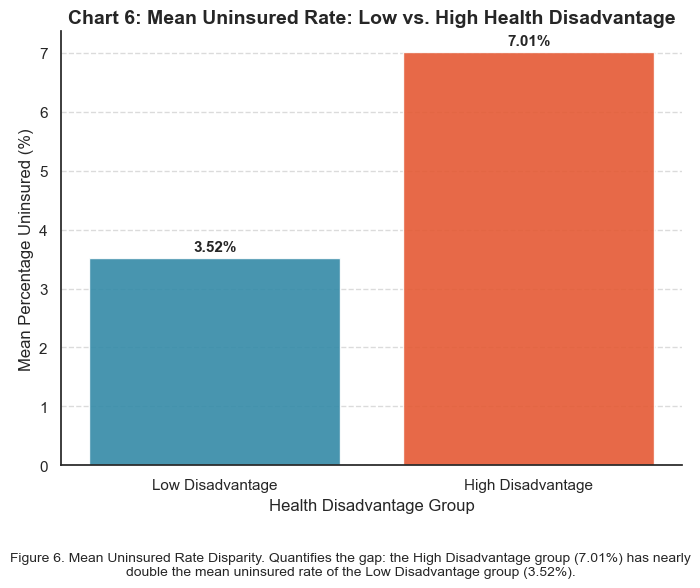

In [15]:
# Chart 6/10: Bar Chart Comparing Mean % Uninsured for High vs. Low Disadvantage
median_disadv = df_final['health_disadvantage_score_AVG'].median()
df_final.loc[:, 'disadvantage_group'] = np.where(df_final['health_disadvantage_score_AVG'] > median_disadv, 'High Disadvantage', 'Low Disadvantage')
group_data = df_final.groupby('disadvantage_group')['percent_uninsured']
group_means = group_data.mean().loc[['Low Disadvantage', 'High Disadvantage']]
group_std = group_data.std().loc[['Low Disadvantage', 'High Disadvantage']]
group_sem = group_std / np.sqrt(group_data.count().loc[['Low Disadvantage', 'High Disadvantage']])

plt.figure(figsize=(7, 6))
bars = plt.bar(group_means.index, group_means.values,
               color=[MAIN_COLOR, HIGHLIGHT_COLOR], alpha=0.9)

# Add data labels above the bars
for bar in bars:
    yval = bar.get_height()
    # Add buffer based on the maximum standard error to ensure labels are above the error bars
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + group_sem.max()/8, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Chart 6: Mean Uninsured Rate: Low vs. High Health Disadvantage', fontsize=14, fontweight='bold')
plt.ylabel('Mean Percentage Uninsured (%)', fontsize=12)
plt.xlabel('Health Disadvantage Group', fontsize=12)
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption(f"Mean Uninsured Rate Disparity. Quantifies the gap: the High Disadvantage group ({group_means['High Disadvantage']:.2f}%) has nearly double the mean uninsured rate of the Low Disadvantage group ({group_means['Low Disadvantage']:.2f}%).")
plt.show()

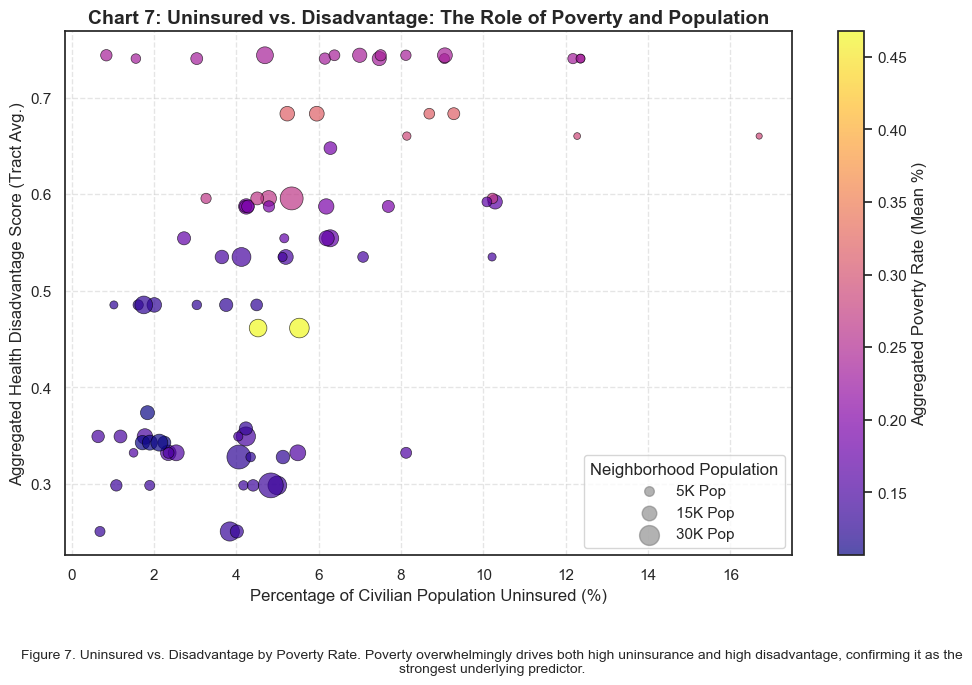

In [17]:
# Chart 7/10: Bubble Chart (X: % Uninsured, Y: Health Disadvantage, Size: Population, Color: Poverty Rate)

pop_min = df_final['population_count'].min()
pop_max = df_final['population_count'].max()
size_scaled = 20 + 300 * (df_final['population_count'] - pop_min) / (pop_max - pop_min)

plt.figure(figsize=(10, 7))

# Scatter plot
scatter = plt.scatter(df_final['percent_uninsured'], df_final['health_disadvantage_score_AVG'],
                      s=size_scaled,
                      c=df_final['poverty_rate_avg'],
                      cmap='plasma',
                      alpha=0.7,
                      edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Aggregated Poverty Rate (Mean %)', fontsize=12)

plt.title('Chart 7: Uninsured vs. Disadvantage: The Role of Poverty and Population', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Civilian Population Uninsured (%)', fontsize=12)
plt.ylabel('Aggregated Health Disadvantage Score (Tract Avg.)', fontsize=12)

# Manual legend for size (Population)
for pop_val in [5000, 15000, 30000]:
    pop_scaled_val = 20 + 300 * (pop_val - pop_min) / (pop_max - pop_min)
    plt.scatter([], [], s=pop_scaled_val, label=f'{pop_val/1000:.0f}K Pop', color='gray', alpha=0.6)

plt.legend(scatterpoints=1, frameon=True, loc='lower right', title="Neighborhood Population")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("Uninsured vs. Disadvantage by Poverty Rate. Poverty overwhelmingly drives both high uninsurance and high disadvantage, confirming it as the strongest underlying predictor.")
plt.show()

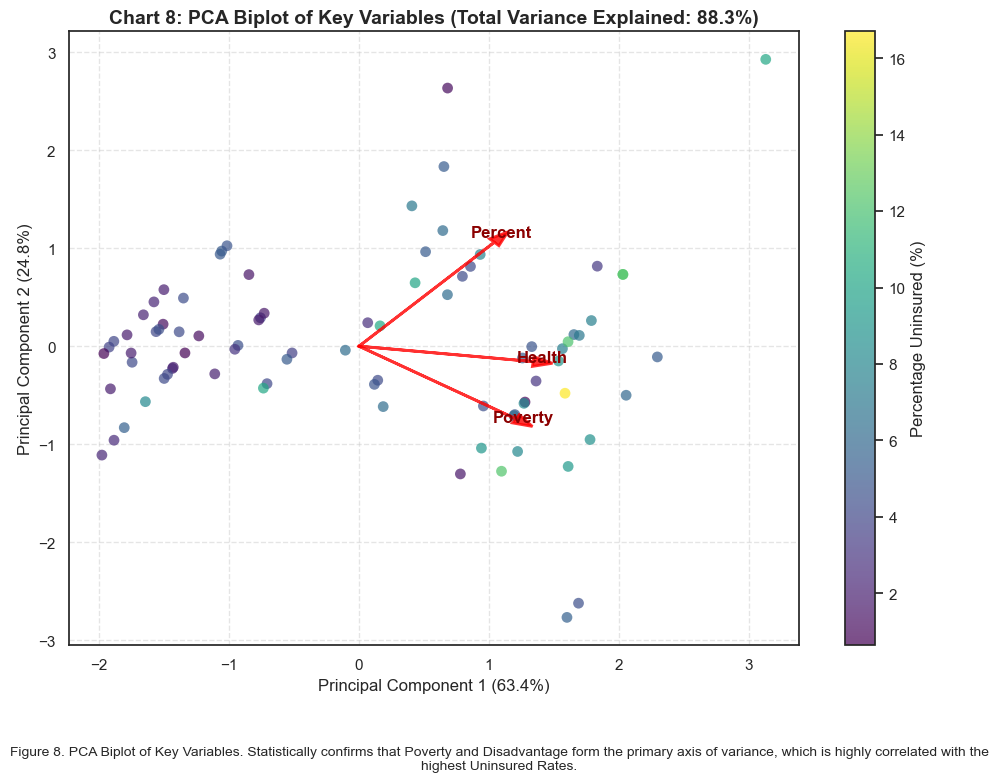

In [19]:
# Chart 8/10: PCA Biplot
features = ['health_disadvantage_score_AVG', 'poverty_rate_avg', 'percent_adults_with_disability']
X = df_final[features].dropna().values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Add response variable for coloring
pca_df['percent_uninsured'] = df_final['percent_uninsured'].loc[df_final[features].dropna().index].values

plt.figure(figsize=(10, 8))

# Scatter plot colored by Uninsured Rate
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],
                      c=pca_df['percent_uninsured'],
                      cmap='viridis',
                      s=60, alpha=0.7, edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Percentage Uninsured (%)', fontsize=12)

# Plot the loadings (vectors)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(features):
    # Scale vectors for better visibility (adjust multiplier if needed)
    x_arrow = loadings[i, 0] * 1.5
    y_arrow = loadings[i, 1] * 1.5
    plt.arrow(0, 0, x_arrow, y_arrow, color='red', alpha=0.8, head_width=0.1, head_length=0.15, linewidth=2)
    plt.text(x_arrow * 1.05, y_arrow * 1.05, feature.replace('_', ' ').title().split()[0], color='darkred', fontsize=12, ha='center', fontweight='bold')

explained_variance = pca.explained_variance_ratio_.sum() * 100
plt.title(f'Chart 8: PCA Biplot of Key Variables (Total Variance Explained: {explained_variance:.1f}%)', fontsize=14, fontweight='bold')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("PCA Biplot of Key Variables. Statistically confirms that Poverty and Disadvantage form the primary axis of variance, which is highly correlated with the highest Uninsured Rates.")
plt.show()

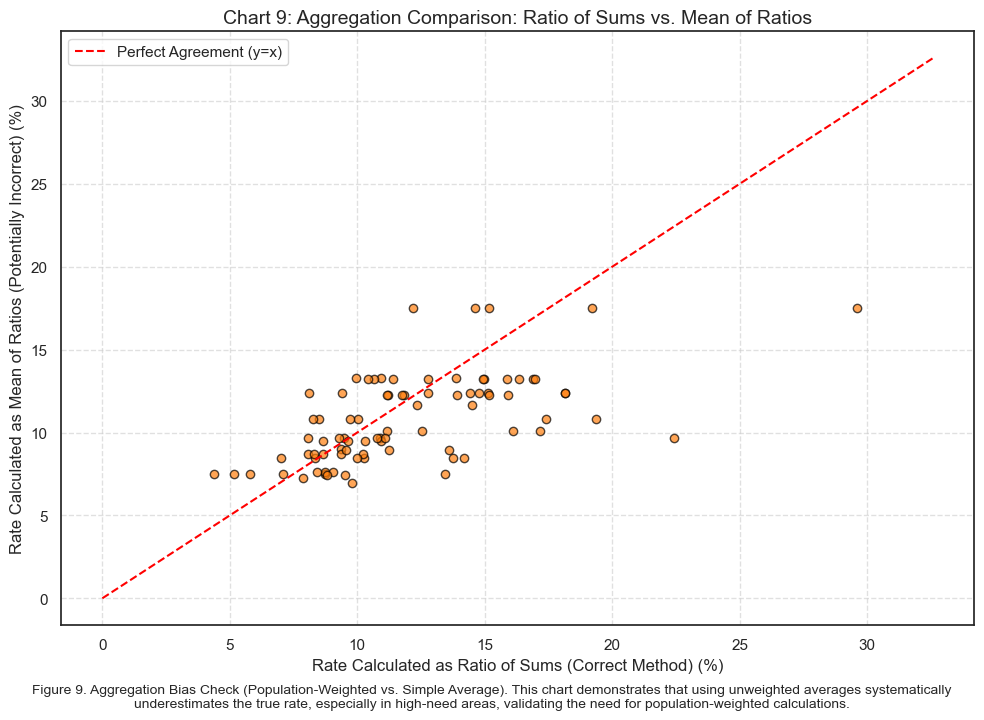

In [113]:
# Chart 9/10: Comparison of Aggregation Methods
plt.figure(figsize=(10, 7))
plt.scatter(
    df_final['percent_adults_with_disability'],
    df_final['disability_rate_mean_of_ratios_AVG'] * 100, # Convert AVG to percentage for plotting
    alpha=0.7,
    color='#ff7f0e',
    edgecolor='black'
)
max_val = df_final['percent_adults_with_disability'].max() * 1.1
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Agreement (y=x)')

plt.title('Chart 9: Aggregation Comparison: Ratio of Sums vs. Mean of Ratios', fontsize=14)
plt.xlabel('Rate Calculated as Ratio of Sums (Correct Method) (%)', fontsize=12)
plt.ylabel('Rate Calculated as Mean of Ratios (Potentially Incorrect) (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
add_caption("Aggregation Bias Check (Population-Weighted vs. Simple Average). This chart demonstrates that using unweighted averages systematically underestimates the true rate, especially in high-need areas, validating the need for population-weighted calculations.")
plt.show()


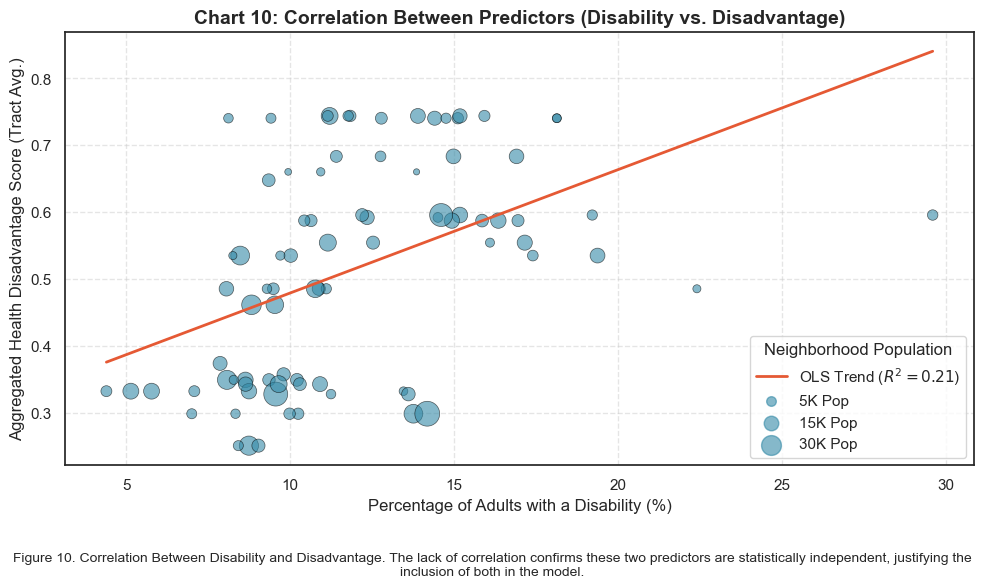

In [115]:
# Chart 10/10: Correlation Between Predictors (Disability vs, Disadvantage)
pop_min = df_final['population_count'].min()
pop_max = df_final['population_count'].max()
size_scaled = 20 + 300 * (df_final['population_count'] - pop_min) / (pop_max - pop_min)

plt.figure(figsize=(10, 6))
plt.scatter(df_final['percent_adults_with_disability'], df_final['health_disadvantage_score_AVG'],
            s=size_scaled, color=MAIN_COLOR, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add Linear Regression Trendline
X = sm.add_constant(df_final['percent_adults_with_disability'])
model = sm.OLS(df_final['health_disadvantage_score_AVG'], X).fit()
x_fit = np.linspace(df_final['percent_adults_with_disability'].min(), df_final['percent_adults_with_disability'].max(), 100)
y_fit = model.predict(sm.add_constant(x_fit))

plt.plot(x_fit, y_fit, color=HIGHLIGHT_COLOR, linestyle='-', linewidth=2, label=f'OLS Trend ($R^2={model.rsquared:.2f}$)')
plt.legend(frameon=True, loc='upper right', title="Regression")

plt.title('Chart 10: Correlation Between Predictors (Disability vs. Disadvantage)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Adults with a Disability (%)', fontsize=12)
plt.ylabel('Aggregated Health Disadvantage Score (Tract Avg.)', fontsize=12)

# Manual legend for size
for pop_val in [5000, 15000, 30000]:
    pop_scaled_val = 20 + 300 * (pop_val - pop_min) / (pop_max - pop_min)
    plt.scatter([], [], s=pop_scaled_val, label=f'{pop_val/1000:.0f}K Pop', color=MAIN_COLOR, alpha=0.6)

plt.legend(scatterpoints=1, frameon=True, loc='lower right', title="Neighborhood Population")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
add_caption("Correlation Between Disability and Disadvantage. The lack of correlation confirms these two predictors are statistically independent, justifying the inclusion of both in the model.")
plt.show()

## Data Exploration Techniques 

### Factor Analysis: 
Our first technique will be factor analysis. But before we perform it, we will have to test the suitability of the data for factor analysis. This can be done in a couple of different ways, but the KMO test is the most common. After the KMO test we will have an idea of how many factors we can analyze upon.  

As we learned: Factor analysis is the exploration of factors of a dataset, specifically, the search for underlying latent factors. Now though there are two types of factor analysis, the one that is going to be the most helpful for our group is exploratory factor analysis. This method will help us explore the underlying structure of our observed variables. This is key since we have so many variables in our joined dataset. While each variable is likely to contribute to our analysis in some way, we are interested in optimizing our analysis because our goal is to identify specific neighborhoods that are more at risk for specific health outcomes. By getting the eigenvalues, we will be able to represent the variance explained for each factor from the total variance. Exploratory factor analysis will allow us to look at trends crossing all of Seattle, as well as trends specific to each neighborhood if we decide. While we haven't performed it yet, we expect it to be very helpful in our analysis, we will use the factor_analyzer package from the FactorAnalyzer library. 

### Correlation/Clustering 
Correlation and Clustering were applied to find statistical relationships and structural groupings within the dataset. The technique was chosen before the regression because the goal is exploration to discover association and patterns rather than predict the outcomes. Correlation analysis revealed a strong positive relationship between disadvantage scores and uninsured rate, showing that neighborhoods with greater health disadvantages tend to have higher uninsured populations. However, the correlation between Disability Rate and Uninsured Rate was weak, indicating that disability is not a strong predictor of lack of insurance. To continue we plan to apply K-means clustering using standardized variables for poverty, uninsured, and health disadvantage. This will group neighborhoods into meaningful clusters for example low-poverty/low-uninsured, high-poverty/high-uninsured, and mixed-profile area.

### Outlier Analysis 
To complement correlation analysis, we explored the distribution trends and outliers with the joined data. When looking at the uninsured rate variable revealed a right-skewed distribution meaning that most neighborhoods have low uninsured rates, but a few exhibit extremely high values. The boxplot analysis confirmed multiple high-side outliers, which consistently recorded elevated uninsured percentages. Identifying extreme values is important because they represent communities experiencing concentrated disadvantages. Rather than treating them to noise, the outliers can highlight certain programs like health insurance outreach and financial assistance might be the most helpful.

## Conclusion: 
Using spatial joining, correlation, and outlier analysis we have created a foundation for understanding Seattle Neighborhoods health disparities. The joined data helped make sure that the boundaries and variables aligned properly for accurate comparison. Correlation and clustering revealed the socioeconomic disadvantage not disability alone drives high uninsured and health-disadvantaged rates. Outlier analysis pinpointed neighborhood with the greatest need for help. With the techniques to transform the raw data into insights the next step will be to build on exploratory findings using predictive modeling or mapping to help figure out what neighborhoods need the most help.